In [9]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
import keras
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
print(os.listdir("../input"))

['cifar-10-python.tar.gz', 'cifar-10-batches-py']


In [10]:
from os import listdir, makedirs
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
datasets_dir = join(cache_dir, 'datasets') # /cifar-10-batches-py
if not exists(datasets_dir):
    makedirs(datasets_dir)


!cp ../input/cifar-10-python.tar.gz ~/.keras/datasets/
!ln -s  ~/.keras/datasets/cifar-10-python.tar.gz ~/.keras/datasets/cifar-10-batches-py.tar.gz
!tar xzvf ~/.keras/datasets/cifar-10-python.tar.gz -C ~/.keras/datasets/

ln: failed to create symbolic link '/root/.keras/datasets/cifar-10-batches-py.tar.gz': File exists
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [11]:
# Load CIFAR10 data
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select a single class images (birds)
X_train = X_train[y_train.flatten() == 2]

In [12]:
X_train.shape

(5000, 32, 32, 3)

In [13]:
import os
import numpy as np
from tensorflow.keras.datasets import cifar10
from PIL import Image

# Load CIFAR10 data
(X_train, y_train), (_, _) = cifar10.load_data()

# Select a single class images (class 2: birds)
X_train_birds = X_train[y_train.flatten() == 2]

# Directory to save images
save_dir = 'cifar10_birds'

# Create directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save images
for i, img in enumerate(X_train_birds):
    img = Image.fromarray(img)
    img.save(os.path.join(save_dir, f'bird_{i}.png'))

print(f"Saved {len(X_train_birds)} images in {save_dir}")


Saved 5000 images in cifar10_birds


In [6]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

## **The Generator** 


To learn a generator distribution p<sub>g</sub> over data x,the generator builds a mapping function from a prior noise distribution p<sub>z</sub>(z) to data space as G(z). The discriminator outputs, a single scalar representing the probability that x came from training data rather than p<sub>g</sub>.

G and D are both trained simultaneously: we adjust parameters for G to minimize log(1 - D(G(z)) and adjust parameters for D to minimize logD(x), as if they are following the two-player min-max game with value function V (G;D):

![](https://github.com/Ibtastic/Generative-Adversarial-Networks/raw/master/GAN/loss.png)

* In the generator we use a method called  [Upsampling](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) to produce images. I have used Upsampling2D but TransposeConv2d + stride or PixelShuffle could be used alternatively. 



In [7]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

## **The Discriminator**

The discriminator is also a  CNN  with leaky ReLU activations. Many activation functions will work fine with this basic GAN architecture. However, leaky ReLUs are very popular because they help the gradients flow easier through the architecture.

A regular ReLU function works by truncating negative values to 0. This has the effect of blocking the gradients to flow through the network. Instead of the function being zero, leaky ReLUs allow a small negative value to pass through. That is, the function computes the greatest value between the features and a small factor.
Leaky ReLUs represent an attempt to solve the dying ReLU problem. This situation occurs when the neurons get stuck in a state in which ReLU units always output 0s for all inputs. For these cases, the gradients are completely shut to flow back through the network.

> *This is especially important for GANs since the only way the generator has to learn is by receiving the gradients from the discriminator.*

Finally, the discriminator needs to output probabilities. We use a Sigmoid Activation for that.

In [9]:
def build_discriminator():

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=img_shape)
        validity = model(img)
        return Model(img, validity)

A lot of changes have been made in GAN's Architecture since Goodfeloow's original paper , but some things remain the same :-
* Normalizing the input
* The activation function in all except the last layer of the generator must be a relu.
* The activation in the last layer of the generator which is a Dense Layer is tanh activation.
* Same goes for the discriminator, all the layers except the last have relu as activtaion and the last Dense layer uses Sigmoid Activation.
* We use binary_cross_entropy method to calculate loss in both the adversaries.(Though in some papers like [Wasserstein gan](https://arxiv.org/pdf/1701.07875.pdf)  different loss functions is used)

Now some hacks/tips that have been introduced in papers in the last few years to make GANs better are:-
* Using BatchNormalization in all layers except the input layer in the generator and the output layer in the discriminator.
* Using Adam Optimizer for the generator and SGD for the discriminator.
* Adding some random noise to the labels before feeding them to the discriminator.
* Sampling from a Gaussian Distribution instead of a Uniform distribution.
* Construct different mini-batches for real and fake, i.e. each mini-batch needs to contain only all real images or all generated images.
* Pre-training the discriminator.
* Adding some noise to the images before feeding them to the discriminator.

It's not necessary that all of the above tricks will work for your model. You will have to find the ones that do.



In [10]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
def show_imgs(epoch):
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [12]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

Time to train the model! 

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.974176] [G loss: 0.688785]


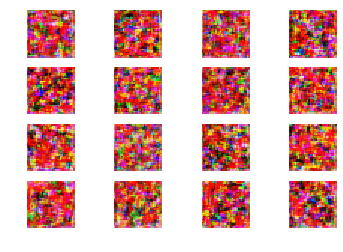

In [13]:
epochs=3000
batch_size=32
display_interval=5000
losses=[]

#normalizing the input
X_train = X_train / 127.5 - 1.
        

        # Adversarial ground truths
valid = np.ones((batch_size, 1))
        #let's add some noise 
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(epochs):

            
            #  Train Discriminator
            

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)
            

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            
            #  Train Generator
            

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = combined.train_on_batch(noise, valid)
            
            # Plot the progress
            if epoch % 5000==0:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
            if epoch % 1000==0:
                losses.append((d_loss[0],g_loss))
                
            if epoch % display_interval == 0:
                 show_imgs(epoch)

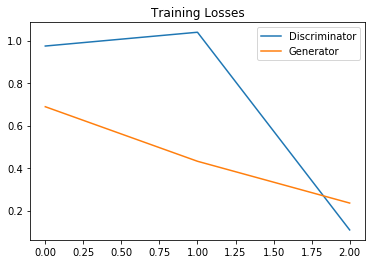

In [14]:
show_losses(losses)

Let's have a look at the original images. It will help us to compare how well our generator did. (I have only selected the bird images for training)

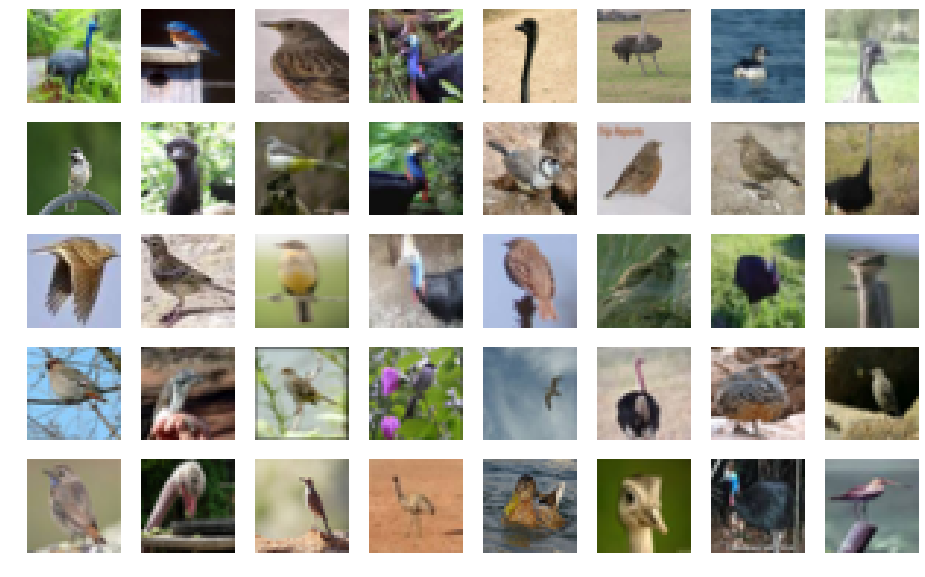

In [15]:
s=X_train[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(s):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

Some images produced by the generator after training for 30000 epochs

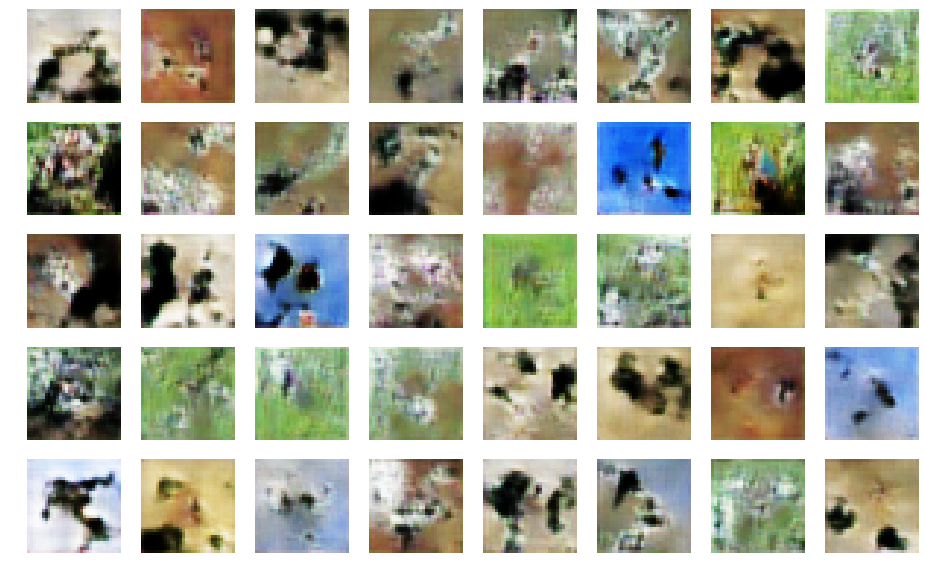

In [16]:
noise = np.random.normal(size=(40, latent_dim))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5

save_dir = '/kaggle/working/generated_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(generated_images):
    ax[i//8, i%8].imshow(img)
    ax[i//8, i%8].axis('off')
    img_filename = os.path.join(save_dir, f'generated_image_{i}.png')
    plt.imsave(img_filename, img)
        
plt.show()

In [17]:
from os import listdir, makedirs
from os.path import join, exists, expanduser
import keras
import numpy as np
from PIL import Image
from os import makedirs, path, environ

# Directory to save bird images
save_dir = '/kaggle/working/cifar10_birds'
if not path.exists(save_dir):
    makedirs(save_dir)

for i, img_array in enumerate(X_train):
    img_array = np.uint8(img_array)
    img = Image.fromarray(img_array)
    img = img.convert('RGB')  # Ensure the image is RGB mode (CIFAR-10 images are RGB)
    img.save(os.path.join(save_dir, f'bird_{i}.png'))

print(f'Saved {len(X_train)} bird images to {save_dir}')

Saved 5000 bird images to /kaggle/working/cifar10_birds


In [29]:
from cleanfid import fid
score = fid.compute_fid('/kaggle/working/generated_images', '/kaggle/working/cifar10_birds')

ModuleNotFoundError: No module named 'cleanfid'

In [6]:
import shutil
shutil.make_archive("zip_main", 'zip', "/kaggle/working/cifar10_birds")

'/kaggle/working/zip_main.zip'

In [22]:
shutil.make_archive("zip_main2", 'zip', "/kaggle/working/generated_images")

'/kaggle/working/zip_main2.zip'